# Modeling and Interpreting the Intersection of Poverty and Environment
Authors: Clayton Coffman, Chris Joyce, Adam Miner

In [1]:
#Imports

import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

%matplotlib inline

In [2]:
#Bring in the dataset
all_df = pd.read_csv('all_data.csv')

In [3]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216929 entries, 0 to 216928
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          216929 non-null  int64  
 1   tractid             216929 non-null  int64  
 2   tract               216929 non-null  object 
 3   county              216929 non-null  object 
 4   state               216929 non-null  object 
 5   pop                 216929 non-null  float64
 6   incpc               216929 non-null  float64
 7   ppov                216929 non-null  float64
 8   hinc                216929 non-null  float64
 9   phs                 216929 non-null  float64
 10  mrent               216929 non-null  float64
 11  mhmval              216929 non-null  float64
 12  pown                216929 non-null  float64
 13  pmulti              216929 non-null  float64
 14  year                216929 non-null  int64  
 15  tractid_nanda       216929 non-nul

In [4]:
all_df.isnull().sum().sum() #no null values

0

In [5]:
#rearrange the columns
all_df = all_df[['Unnamed: 0', 'tractid', 'tract', 'county', 'state', 'year', 'tractid_nanda', 'year_nanda', 'pop', 'incpc', 'ppov', 'hinc', 'phs',
                        'mrent', 'mhmval', 'pown', 'pmulti', 'open_urban_space', 'low_development', 
                        'medium_development', 'high_development', 'unclassified', 'forested', 'cultivated']]

In [6]:
#Standard Scale the variables, based on year

ss = StandardScaler()
 
all_df.loc[all_df['year'] == 2000, 8:] = ss.fit_transform(all_df.iloc[(all_df.iloc[:, 5] == 2000).values, 8:])
all_df.loc[all_df['year'] == 2012, 8:] = ss.fit_transform(all_df.iloc[(all_df.iloc[:, 5] == 2012).values, 8:])
all_df.loc[all_df['year'] == 2019, 8:] = ss.fit_transform(all_df.iloc[(all_df.iloc[:, 5] == 2019).values, 8:])

C:\Users\Adam\AppData\Local\Temp\ipykernel_16164\1332265370.py:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  all_df.loc[all_df['year'] == 2000, 8:] = ss.fit_transform(all_df.iloc[(all_df.iloc[:, 5] == 2000).values, 8:])
C:\Users\Adam\AppData\Local\Temp\ipykernel_16164\1332265370.py:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  all_df.loc[all_df['year'] == 2012, 8:] = ss.fit_transform(all_df.iloc[(all_df.iloc[:, 5] == 2012).values, 8:])
C:\Users\Adam\AppData\Local\Temp\ipykernel_16164\1332265370.py:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  all_df.loc[all_df['year'] == 2019, 8:] = ss.fit_transform(all

In [7]:
all_df.head()

,Unnamed: 0,tractid,tract,county,state,year,tractid_nanda,year_nanda,pop,incpc,...,mhmval,pown,pmulti,open_urban_space,low_development,medium_development,high_development,unclassified,forested,cultivated
0,0,1001020100,Census Tract 201,Autauga County,AL,2000,1001020100,2000,-1.245943,-0.352016,...,-0.558253,-0.285072,-0.872083,0.132182,-0.786749,-0.864573,-0.542587,0.614903,1.045106,0.041881
1,1,1001020200,Census Tract 202,Autauga County,AL,2000,1001020200,2000,-1.211551,-0.680707,...,-0.595377,-0.199205,-0.788144,1.630459,-0.200770,-0.510381,-0.359526,-0.539466,0.654034,-0.491947
2,2,1001020300,Census Tract 203,Autauga County,AL,2000,1001020300,2000,-0.333389,-0.298837,...,-0.525143,0.416948,-0.678781,1.054657,0.156977,-0.668035,-0.406018,-0.496259,0.411674,-0.014839
3,3,1001020400,Census Tract 204,Autauga County,AL,2000,1001020400,2000,0.427268,-0.169821,...,-0.425812,0.292499,-0.812455,0.938944,0.577969,-0.696225,-0.465568,-0.324905,0.218059,-0.084181
4,4,1001020500,Census Tract 205,Autauga County,AL,2000,1001020500,2000,1.363503,0.269608,...,-0.156981,0.564464,-0.408313,-0.059217,0.169809,-0.219595,-0.286159,-0.419139,-0.074567,0.646982


In [9]:
#Pull out ppov (y) and X values

X = all_df.drop(columns = ['Unnamed: 0', 'tractid', 'tract', 'county', 'state', 'year', 'tractid_nanda', 'year_nanda', 'ppov', 'pop', 'incpc', 'hinc', 'phs', 'mrent', 'mhmval', 'pown', 'pmulti'])
y = all_df['ppov']

In [10]:
#train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [11]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [12]:
print(f"Training score: {lr.score(X_train, y_train)}")
print(f"Test score: {lr.score(X_test, y_test)}")

Training score: 0.10065074342581715
Test score: 0.0949360552041888


In [13]:
y_base = np.array([np.mean(y_train)] * len(y_train)).reshape(-1,1) #gets the mean of the null model as an array
print(f"Baseline score: {lr.score(X_train, y_base)}")

Baseline score: 0.0


In [14]:
y_pred = lr.predict(X)

In [15]:
all_df['predicted_ppov'] = y_pred

In [16]:
X_sm = sm.add_constant(X)
model = sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   ppov   R-squared (uncentered):                   0.099
Model:                            OLS   Adj. R-squared (uncentered):              0.099
Method:                 Least Squares   F-statistic:                              3413.
Date:                Mon, 01 May 2023   Prob (F-statistic):                        0.00
Time:                        16:24:34   Log-Likelihood:                     -2.9648e+05
No. Observations:              216929   AIC:                                  5.930e+05
Df Residuals:                  216922   BIC:                                  5.930e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
open_urban_space       0.3173      0.046      6.843      0.000       0.226       0.408
low_development        0.6432      0.067      9.628      0.000       0.512       0.774
medium_development     0.7753      0.077     10.110      0.000       0.625       0.926
high_development       0.7773      0.061     12.769      0.000       0.658       0.897
unclassified           0.4761      0.054      8.835      0.000       0.370       0.582
forested               0.9428      0.103      9.139      0.000       0.741       1.145
cultivated             0.7470      0.084      8.929      0.000       0.583       0.911
==============================================================================
Omnibus:                    69012.198   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           249106.202
Skew:                           1.586   Prob(JB):                         0.00
Kurtosis:                       7.183   Cond. No.                         148.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

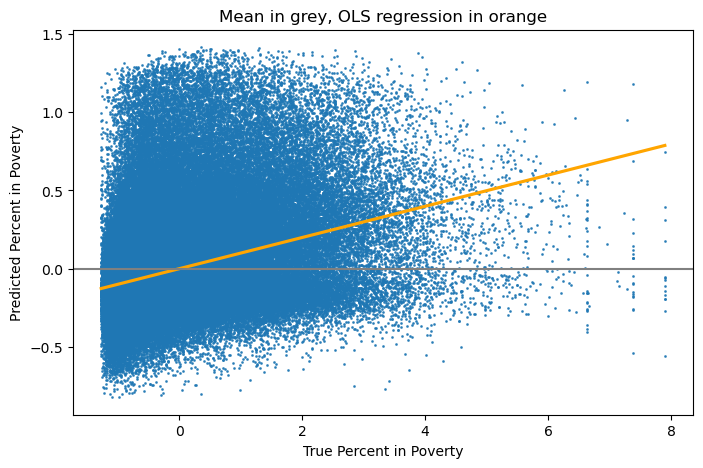

In [17]:
plt.figure(figsize = (8, 5))
sns.regplot(data = all_df, x = 'ppov', y = y_pred, ci=None,
            scatter_kws = {'s': 1},
            line_kws = {'color': 'orange'})
plt.axhline(all_df['ppov'].mean(), color = 'grey')
plt.xlabel('True Percent in Poverty')
plt.ylabel('Predicted Percent in Poverty')
plt.title('Mean in grey, OLS regression in orange');
plt.show()